# Solution 2: Ensemble learning with model weighting

## Load Packages and libraries

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


import data_prep_model_fit, drift
from sklearn.metrics import accuracy_score
from mleng_workshop_drift import addressing_solutions

## Preparing the model


In [53]:
red_wine_dataset = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=";")
white_wine_dataset = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep=";")

In [54]:
wine_dataset = data_prep_model_fit.data_transform(red_wine_dataset, white_wine_dataset)
wine_dataset_train, wine_dataset_test = data_prep_model_fit.data_labels_change(wine_dataset)
X_train, y_train, X_test, y_test = data_prep_model_fit.data_split(wine_dataset_train, wine_dataset_test)
lgbm_model, params = data_prep_model_fit.lgbm_fit(X_train, y_train)

C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


In [55]:
cat_features_name = [11]
model_params = {
        'learning_rate': 0.1,
        'max_depth': None,
        'n_estimators': 500,
        'min_child_samples': 10,
        'n_jobs': 1,
        'random_state': 1234,
    }

In [63]:
stack = addressing_solutions.stacking_model(X_train, y_train, model_params)

C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [57]:
accuracy_list = []

In [58]:
stack.fit(X_train, y_train)
accuracy_list.append(stack.score(X_test,y_test))
stack.score(X_test,y_test)

C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8826471719892266

## Corrupting the model : batch 1
We now corrupt our dataset with a real concept drift


In [59]:
data_generated = drift.dataset_generator_yield(data=wine_dataset_test, nb_sample=500)
dataset_sample = next(data_generated)
wine_dataset_corrupted_batch_1 = drift.drift_generator_concept_drift(data=dataset_sample,
                                                             column_name="alcohol",
                                                             value=11,
                                                             action="greater",
                                                             label_col="quality",
                                                             label_value=0)

In [60]:
X_test_corrupted_batch_1 = wine_dataset_corrupted_batch_1.loc[:, wine_dataset_corrupted_batch_1.columns != "quality"]
y_test_corrupted_batch_1 = wine_dataset_corrupted_batch_1["quality"]

In [61]:
accuracy_list.append(stack.score(X_test_corrupted_batch_1, y_test_corrupted_batch_1))
print(stack.score(X_test_corrupted_batch_1, y_test_corrupted_batch_1))

0.66


In [62]:
stack.fit(X_test_corrupted_batch_1, y_test_corrupted_batch_1)
accuracy_list.append(stack.score(X_test_corrupted_batch_1,y_test_corrupted_batch_1))
stack.score(X_test_corrupted_batch_1,y_test_corrupted_batch_1)

0.996

In [67]:
def gradual_drift(data_train: pd.DataFrame,
                  data_to_compare: pd.DataFrame,
                  column_name: str,
                  value_drift: float,
                  model_params,
                  action: str = "increase",
                  nb_sample: int = 100,
                  nb_days: int = 5):
    """
    Generates a gradual drift
    Prints an alarm or a warning if a feature drift or anomaly has happened throughout a period of days
    """
    days = 0
    accuracy_list_fit= []
    accuracy_list_no_fit = []
    init_value_drift = value_drift
    X_train_init = data_train.loc[:, data_train.columns != "quality"]
    y_train_init = data_train["quality"]
    init_stack = addressing_solutions.stacking_model(X_train_init, y_train_init, model_params)
    init_stack.fit(X_train_init, y_train_init,)
    accuracy_list_fit.append(init_stack.score(X_train_init,y_train_init))
    accuracy_list_no_fit.append(init_stack.score(X_train_init,y_train_init))
    data_generated = drift.dataset_generator_yield(data=data_to_compare, nb_sample=nb_sample)
    while days <= nb_days:
        print("Day", days, ":")
        dataset_corrupted_batch_1 = drift.drift_generator(data_generated=next(data_generated),
                                                          column_name=column_name,
                                                          value_of_drift=value_drift,
                                                          action=action)
        X_test_corrupted, y_test_corrupted = addressing_solutions.dataset_concat(data_train, dataset_corrupted_batch_1)
        model_stack = addressing_solutions.stacking_model(X_test_corrupted, y_test_corrupted, model_params)
        model_stack.fit(X_train, y_train)
        accuracy_list_fit.append(model_stack.score(X_test_corrupted,y_test_corrupted))
        accuracy_list_no_fit.append(init_stack.score(X_test_corrupted,y_test_corrupted))
        data_train = pd.concat([data_train, dataset_corrupted_batch_1], axis=0)
        days += 1
        value_drift += init_value_drift
    return accuracy_list_fit, accuracy_list_no_fit

In [74]:
accuracy_list_fit, accuracy_list_no_fit = gradual_drift(wine_dataset_train,
                                                        wine_dataset_test,
                                                        "alcohol",
                                                        5,
                                                        params,
                                                        "multiply",
                                                        500,
                                                        5)

C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _lo

Day 0 :


C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _lo

Day 1 :


C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _lo

Day 2 :


C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _lo

Day 3 :


C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _lo

Day 4 :


C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _lo

Day 5 :


C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _lo

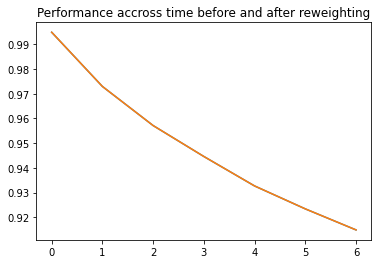

In [75]:
plt.plot(accuracy_list_fit)
plt.plot(accuracy_list_no_fit)
plt.title("Performance accross time before and after reweighting");

## Essayer juste en refittant un light gbm